## GPT2 reproduction of 124M
124m reproduction 
12 layers, 768 channels

Notebook will be converted into a python script for final training

### Load pretrained snapshot
using HF version since it's pytorch based

In [ ]:
from transformers import GPT2LMHeadModel
import matplotlib.pyplot as plt

In [ ]:
model_hf = GPT2LMHeadModel.from_pretrained('gpt2') #124M model, if you want 1B model need XL
sd_hf = model_hf.state_dict()

for k,v in sd_hf.items():
    print(k, v.shape)

In [ ]:
# first 20 of the first layer for token and position embeddings
sd_hf['transformer.wte.weight'].view(-1)[:20], sd_hf['transformer.wpe.weight'].view(-1)[:20]

In [ ]:
plt.imshow(sd_hf['transformer.wpe.weight'], cmap='gray')

In [ ]:
# since jagged, it's not completely trained
plt.plot(sd_hf['transformer.wpe.weight'][:,50])
plt.plot(sd_hf['transformer.wpe.weight'][:,100])
plt.plot(sd_hf['transformer.wpe.weight'][:,150])
plt.plot(sd_hf['transformer.wpe.weight'][:,200])
plt.plot(sd_hf['transformer.wpe.weight'][:,250])

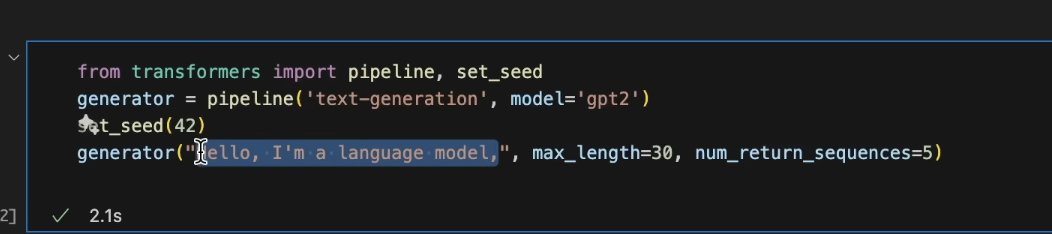

In [ ]:
from transformers import pipeline, set_seed

generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator('Hello, I\'m a language model,',  max_length=35, num_return_sequences=5)

### Base GPT2 Class

In [10]:
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from pathlib import Path
import tiktoken
import matplotlib.pyplot as plt

In [25]:
torch.manual_seed(1337)
shake_data = Path('/Users/djemec/data/gpt_train_data/tiny_shakespeare/input.txt')


def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

device = get_device()

using cpu


In [22]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        # ensures that you can split embeddings across the heads
        assert config.n_embd % config.n_head == 0
        # key, query, value projection for all heads in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # acts as a triangle mask to prevent seeing the future, called bias for historic reasons
        self.register_buffer('bias', torch.tril(torch.ones(config.block_size, 
                                                           config.block_size)
                                               ).view(1,1, config.block_size,config.block_size)
                            )

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, n_embd embedding dimensionality 
        # calculate query, key, value for all heads in batch, then move head forward
        # nh - num heads, hs - head size, C  nh*hs aka channels
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1,2) # (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1,2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1,2) # (B, nh, T, hs)
        # attention (materializes the large (T,T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) X (B, nh, T, hs) - > (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # reassemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        # allows for pathway to pass through gradients instead of going through each "box"
        # this is a feed forward network
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length/context
    vocab_size: int = 50257 # num of tokens, 50k merges, 256 bytes, 1 EOT
    n_layer: int = 12 
    n_head: int = 12
    n_embd: int = 768

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd), # weight tokenizer element
            wpe = nn.Embedding(config.block_size, config.n_embd), # weight position element
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # hidden layers aka Transformers
            ln_f = nn.LayerNorm(config.n_embd), #log normalization 
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias = False) # language model head going from embeddings to vocab

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        mean = 0.0
        if isinstance(module, nn.Linear):
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=mean, std=std)

    def forward(self, idx, targets=None):
        # idx is shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f'Cannot forward sequence, out of context'
        # forward the token and positions
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos) # (T, n_embd)
        tok_emb = self.transformer.wte(idx) # (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the block
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and head
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss
    
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model


class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
        with open(shake_data, 'r', encoding='utf-8') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B*T)} batches')

        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T 
        # if loading the next batch would be out of bounds, advance to next shard
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y

### Load Pretrained

In [ ]:
model = GPT.from_pretrained('gpt2')
print('model loaded')

In [ ]:
num_sequences = 5
max_seq_length = 30
#device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model.eval() # put to evaluation mode
model.to(device)

### Run the model to generate

In [ ]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode('Hello, I\'m a language model,')
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_sequences, 1)
x = tokens.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.size(1) < max_seq_length:
    with torch.no_grad():
        logits = model(x)
        logits = logits[:,-1,:] # only sample last row
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1)
        xcol = torch.gather(topk_indices, -1, ix)
        x = torch.cat((x, xcol), dim=1)
         
for i in range(num_sequences):
    tokens = x[i, :max_seq_length].tolist()
    decoded = enc.decode(tokens)
    print('>',decoded)

## Creating model for training

In [23]:
train_loader = DataLoaderLite(B=4, T=32)
model = GPT(GPTConfig())
model.to(device)
lossi = []

learning_rate = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loaded 338025 tokens
1 epoch = 2640 batches


In [27]:
for i in range(50):
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f'step {i}: loss of {loss.item()}')
    lossi.append(loss.item())

step 0: loss of 6.253199577331543
step 1: loss of 5.686936378479004
step 2: loss of 6.154860019683838
step 3: loss of 6.432044506072998
step 4: loss of 5.8490190505981445
step 5: loss of 7.353795528411865
step 6: loss of 8.14336109161377
step 7: loss of 6.046887397766113
step 8: loss of 6.215943336486816
step 9: loss of 5.638653755187988
step 10: loss of 6.955679893493652
step 11: loss of 6.720803260803223
step 12: loss of 5.669089317321777
step 13: loss of 6.563521862030029
step 14: loss of 7.184201240539551
step 15: loss of 6.666618824005127
step 16: loss of 6.380928993225098
step 17: loss of 6.226799964904785
step 18: loss of 5.7296037673950195
step 19: loss of 5.657430171966553
step 20: loss of 6.058236598968506
step 21: loss of 6.570766448974609
step 22: loss of 7.112997531890869
step 23: loss of 6.723528861999512
step 24: loss of 6.938520431518555
step 25: loss of 5.428607940673828
step 26: loss of 5.256170749664307
step 27: loss of 5.4555535316467285
step 28: loss of 5.523347377

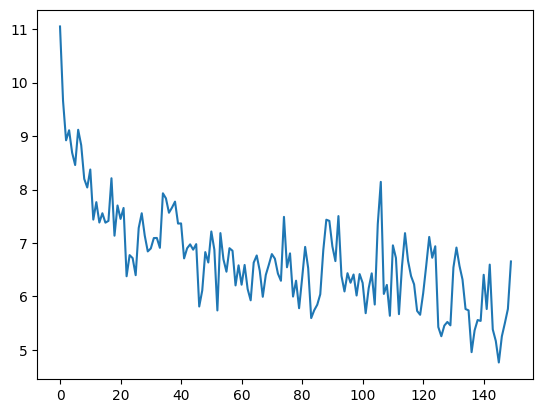

In [28]:
plt.plot(lossi)